# SVM Training on MNIST

In this notebook, we are going to train an L2-SVM model on PYNQ using stochasting gradient descent optimization, to classify handwritten digits of the MNIST data set. We are going to perform training on both the CPU and the FPGA, comparing performance.

## 1. Instantiate ZipML_SGD

First, we instantiate a ZipML_SGD object, that we will use for training and inference.

In [2]:
import numpy as np
import time

Z = ZipML_SGD(on_pynq=0)


## 2. Load and prepare the data

We load the data that is formatted in libsvm format (label feature_index1:feature1 feature_index2:feature2 ...).
Then, we perform a normalization on the features of the data set, where we can specify: (1) The normalization range (-1 to 1 or 0 to 1), (2) if the normalization should happen row-wise or column-wise.

In [2]:
start = time.time()
Z.load_libsvm_data('./mnist/mnist', 10000, 784)
print('Data loaded, time: ' + str(time.time()-start) )
Z.a_normalize(to_min1_1=0, row_or_column='r') # Normalize features of the data set

# Set training related parameters
num_epochs = 100
step_size = 1.0/(1 << 12)
cost_pos = 1.0
cost_neg = 1.5

Data loaded, time: 1.3537251949310303


In [3]:
import pandas as pd
#set_option('display.max_rows',None)
df = pd.DataFrame(Z.a)
df

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's visualize our date set, to take a look at the handwritten digits and to make sure if we have loaded it correctly. 

In [4]:

from PIL import Image
for i in range(0,10):
    array = np.reshape(Z.a[i,1:785], (28,28))
    Image.fromarray((array*255).astype('uint8'), mode='L').convert('RGB').save('out'+ str(i) +'.jpg')  #使用PIL实现图片与numpy数组的相互转化



from IPython.display import display

for i in range(0,10):
    im = Image.open('./out'+str(i)+'.jpg')
    display(im)

## 3. Full precision training using the CPU

Let's perform training on full-precision data using the CPU. With the mnist data set we want to classify between 10 classes (handwritten digits from 0 to 9). For this reason, we perform a 1-vs-all training: For each digit we train a seperate L2-SVM model, that should classify the digit compared to all others.

During the training, we calculate the loss after each epoch (a complete scan over the data set). The convergence of the model is observed by the decreasing loss. After having performed the given number of epochs, we save the trained model in an array.

In [5]:
from livelossplot import PlotLosses
from time import sleep
from matplotlib import pyplot as plt
from livelossplot.outputs import MatplotlibPlot

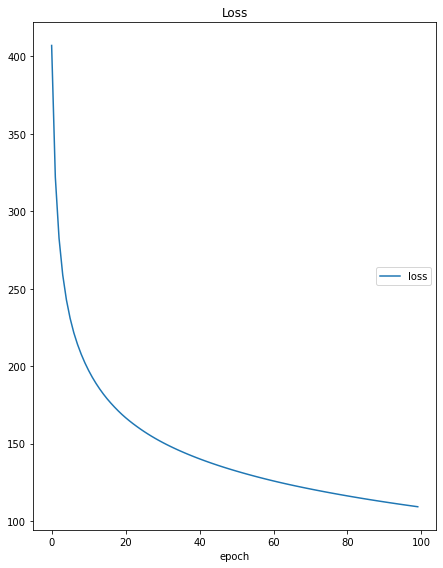

In [16]:
xs_CPU = np.zeros((Z.num_features, 10))
groups = {'loss': ['loss']}
outputs = [MatplotlibPlot()]
plotlosses = PlotLosses(groups=groups, outputs=outputs)
for c in range(0, 1):
    start = time.time()
    Z.b_binarize(c) # Binarize the labels of the data set
    #print('b binarized for ' + str(c) + ", time: " + str(time.time()-start) )
    start = time.time()

    # Train model on the CPU
    x_history = Z.L2SVM_SGD(num_epochs, step_size, cost_pos, cost_neg, regularize=0, use_binarized=1)

    #print('Training time: ' + str(time.time()-start) )
    # Print losses after each epoch
    initial_loss = Z.calculate_L2SVM_loss(np.zeros(Z.num_features), cost_pos, cost_neg, 0, 1)
    #print('Initial loss: ' + str(initial_loss))
    for e in range(0, num_epochs):
        loss = Z.calculate_L2SVM_loss(x_history[:,e], cost_pos, cost_neg, 0, 1)
        plotlosses.update({'loss':  (loss)})
        plotlosses.send()
        #print('Epoch ' + str(e) + ' loss: ' + str(loss) )
    xs_CPU[:,c] = x_history[:,num_epochs-1]

## 对输入特征做1bit量化

In [6]:
# Quantize the features of the data set
Z.a_quantize(quantization_bits=1)

num_levels: 2
a[0]: [1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.

a[3]: [1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

In [15]:
df1 = pd.DataFrame(Z.quantized_a)
pd.set_option('display.max_columns',None)
df1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0

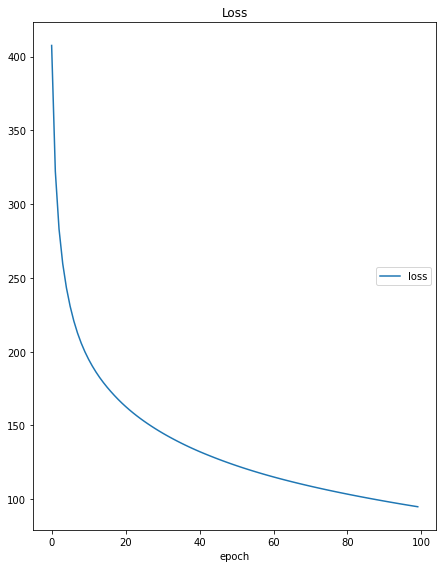

In [18]:
xs_CPU = np.zeros((Z.num_features, 10))
groups = {'loss': ['loss']}
outputs = [MatplotlibPlot()]
plotlosses = PlotLosses(groups=groups, outputs=outputs)
for c in range(0, 1):
    start = time.time()
    Z.b_binarize(c) # Binarize the labels of the data set
    #print('b binarized for ' + str(c) + ", time: " + str(time.time()-start) )
    start = time.time()

    # Train model on the CPU
    x_history = Z.L2SVM_SGD_quant(num_epochs, step_size, cost_pos, cost_neg, regularize=0, use_binarized=1)

    #print('Training time: ' + str(time.time()-start) )
    # Print losses after each epoch
    initial_loss = Z.calculate_L2SVM_loss_quant(np.zeros(Z.num_features), cost_pos, cost_neg, 0, 1)
    #print('Initial loss: ' + str(initial_loss))
    for e in range(0, num_epochs):
        loss = Z.calculate_L2SVM_loss_quant(x_history[:,e], cost_pos, cost_neg, 0, 1)
        plotlosses.update({'loss':  (loss)})
        plotlosses.send()
        #print('Epoch ' + str(e) + ' loss: ' + str(loss) )
    xs_CPU[:,c] = x_history[:,num_epochs-1]

In [21]:
dfx_history = pd.DataFrame(x_history)
pd.set_option('display.max_rows',10)
dfx_history

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,-0.108268,-0.147415,-0.178214,-0.204683,-0.228368,-0.250049,-0.27013,-0.288891,-0.306523,-0.323206,-0.339065,-0.354204,-0.368704,-0.382638,-0.396058,-0.409011,-0.42154,-0.433681,-0.445454,-0.456881,-0.467991,-0.478805,-0.489339,-0.499607,-0.509621,-0.519401,-0.528959,-0.538307,-0.547458,-0.556421,-0.565203,-0.573806,-0.582237,-0.590504,-0.598615,-0.606578,-0.614395,-0.622073,-0.629616,-0.63703,-0.644317,-0.65148,-0.658522,-0.665448,-0.672264,-0.678971,-0.685571,-0.692068,-0.698464,-0.70476,-0.710959,-0.717063,-0.723074,-0.728995,-0.734827,-0.740573,-0.746236,-0.751819,-0.757323,-0.762749,-0.768101,-0.773381,-0.77859,-0.78373,-0.788802,-0.793809,-0.798752,-0.803634,-0.808455,-0.813217,-0.817921,-0.822569,-0.827161,-0.8317,-0.836187,-0.840622,-0.845007,-0.849342,-0.853628,-0.857866,-0.862059,-0.866207,-0.870311,-0.874372,-0.878391,-0.882369,-0.886307,-0.890206,-0.894066,-0.89789,-0.901676,-0.905426,-0.90914,-0.91282,-0.916467,-0.920081,-0.923662,-0.927211,-0.930728,-0.934215
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.

## 考虑不再用float64表示参数
首先,我们先看一下参数的分布情况,因为权重初始化是0,在迭代时按照梯度反方向累加权重,所以分布还是围绕着0

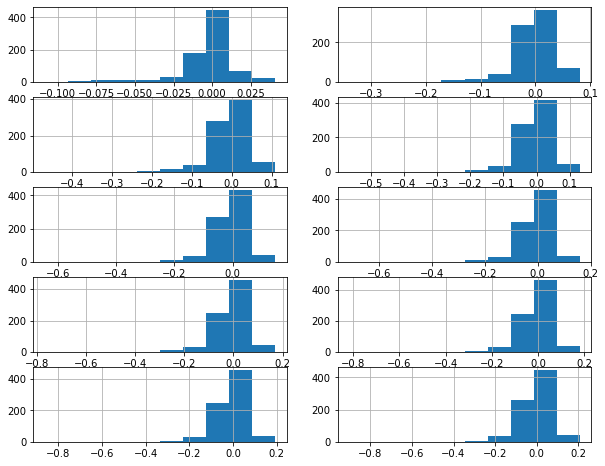

In [46]:
figure,axes=plt.subplots(nrows=5,ncols=2,figsize=(10,8))
for i in range(0,5):
    for j in range(0,2):
        dfx_history[(i*2+j)*10].hist(ax=axes[i][j])
    

## 只使用梯度的符号，signSGD

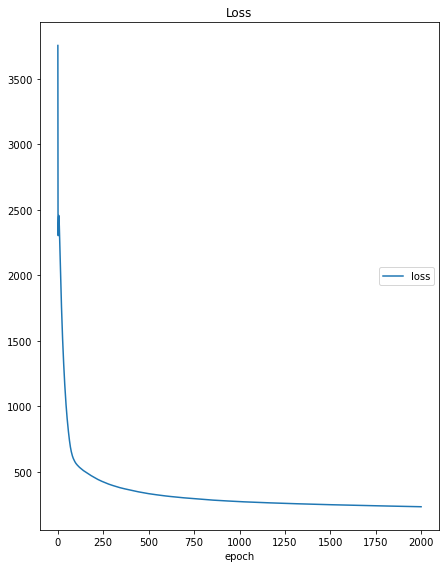

In [1]:
from livelossplot import PlotLosses
from time import sleep
from matplotlib import pyplot as plt
from livelossplot.outputs import MatplotlibPlot
from zipml_sgd import ZipML_SGD
import numpy as np
import time

Z = ZipML_SGD(on_pynq=0)
start = time.time()
Z.load_libsvm_data('./mnist/mnist', 10000, 784)
print('Data loaded, time: ' + str(time.time()-start) )
Z.a_normalize(to_min1_1=0, row_or_column='r') # Normalize features of the data set

# Set training related parameters
num_epochs = 2000
step_size = 1.0/(1 << 12)
cost_pos = 1.0
cost_neg = 1.5
# Quantize the features of the data set
Z.a_quantize(quantization_bits=4)
xs_CPU = np.zeros((Z.num_features, 10))
groups = {'loss': ['loss']}
outputs = [MatplotlibPlot()]
plotlosses = PlotLosses(groups=groups, outputs=outputs)
for c in range(0, 1):
    start = time.time()
    Z.b_binarize(c) # Binarize the labels of the data set
    #print('b binarized for ' + str(c) + ", time: " + str(time.time()-start) )
    start = time.time()

    # Train model on the CPU
    x_history = Z.L2SVM_SGD_quant_signedSGD(num_epochs, step_size, cost_pos, cost_neg, regularize=0, use_binarized=1)

    #print('Training time: ' + str(time.time()-start) )
    # Print losses after each epoch
    initial_loss = Z.calculate_L2SVM_loss_quant(np.zeros(Z.num_features), cost_pos, cost_neg, 0, 1)
    #print('Initial loss: ' + str(initial_loss))
    for e in range(0, num_epochs):
        loss = Z.calculate_L2SVM_loss_quant(x_history[:,e], cost_pos, cost_neg, 0, 1)
        plotlosses.update({'loss':  (loss)})
        plotlosses.send()
        #print('Epoch ' + str(e) + ' loss: ' + str(loss) )
    xs_CPU[:,c] = x_history[:,num_epochs-1]

In [4]:
import pandas as pd
dfx_history = pd.DataFrame(x_history*2**12)
pd.set_option('display.max_rows',None)
dfx_history

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,-3.9990,-7.9235,-10.8065,-12.5395,-13.7005,-14.5615,-15.2415,-15.8100,-16.3030,-16.7370,...,-116.1455,-116.1705,-116.1955,-116.2205,-116.2455,-116.2705,-116.2955,-116.3200,-116.3455,-116.3700
1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
9,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [7]:
Z.quantized_a

array([[8., 0., 0., ..., 0., 0., 0.],
       [8., 0., 0., ..., 0., 0., 0.],
       [8., 0., 0., ..., 0., 0., 0.],
       ...,
       [8., 0., 0., ..., 0., 0., 0.],
       [8., 0., 0., ..., 0., 0., 0.],
       [8., 0., 0., ..., 0., 0., 0.]])

# 对未量化的版本做signSGD

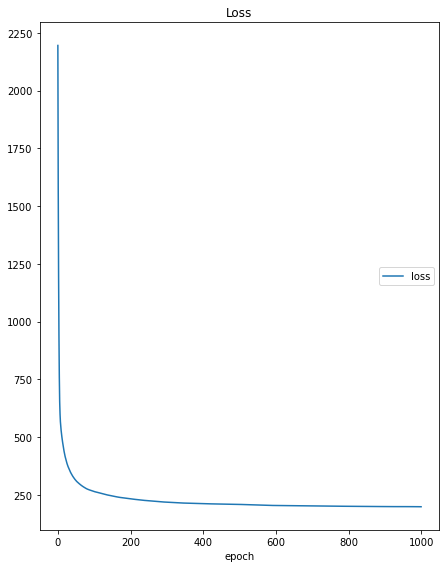

In [1]:
from livelossplot import PlotLosses
from time import sleep
from matplotlib import pyplot as plt
from livelossplot.outputs import MatplotlibPlot
from zipml_sgd import ZipML_SGD
import numpy as np
import time

Z = ZipML_SGD(on_pynq=0)
start = time.time()
Z.load_libsvm_data('./mnist/mnist', 10000, 784)
print('Data loaded, time: ' + str(time.time()-start) )
Z.a_normalize(to_min1_1=0, row_or_column='r') # Normalize features of the data set

# Set training related parameters
num_epochs = 1000
step_size = 1.0/(1 << 12)
cost_pos = 1.0
cost_neg = 1.5
# Quantize the features of the data set
Z.a_quantize(quantization_bits=1)
xs_CPU = np.zeros((Z.num_features, 10))
groups = {'loss': ['loss']}
outputs = [MatplotlibPlot()]
plotlosses = PlotLosses(groups=groups, outputs=outputs)
for c in range(0, 1):
    start = time.time()
    Z.b_binarize(c) # Binarize the labels of the data set
    #print('b binarized for ' + str(c) + ", time: " + str(time.time()-start) )
    start = time.time()

    # Train model on the CPU
    x_history = Z.L2SVM_SGD_signed(num_epochs, step_size, cost_pos, cost_neg, regularize=0, use_binarized=1)

    #print('Training time: ' + str(time.time()-start) )
    # Print losses after each epoch
    initial_loss = Z.calculate_L2SVM_loss(np.zeros(Z.num_features), cost_pos, cost_neg, 0, 1)
    #print('Initial loss: ' + str(initial_loss))
    for e in range(0, num_epochs):
        loss = Z.calculate_L2SVM_loss(x_history[:,e], cost_pos, cost_neg, 0, 1)
        plotlosses.update({'loss':  (loss)})
        plotlosses.send()
        #print('Epoch ' + str(e) + ' loss: ' + str(loss) )
    xs_CPU[:,c] = x_history[:,num_epochs-1]

# 参数范围都小于一,我们先试着int表示参数,参数范围
就是说floor(

The training time on the FPGA is approximately 0.6 seconds for one digit, whereas on the CPU it was 20 secons. 2 orders of magnitude speedup!

In [9]:
M=np.array([-1.0,0.0,3.0])

In [10]:
(M>=0).astype(int)-(M<=0).astype(int)

array([-1,  0,  1])

In [6]:
2*((a<0)-0.5)

array([ 1., -1., -1.])

In [7]:
2*((a>0)-0.5)

array([-1., -1.,  1.])

In [8]:
2*((a==0)-0.5)

array([-1.,  1., -1.])